In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
def evaluate_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

def plot_metricas_modelos(modelos_metricas):
    # nomes dos modelos
    nomes_modelos = [m[0] for m in modelos_metricas]

    # todas as métricas existentes
    metricas = sorted(list({k for _, d in modelos_metricas for k in d.keys()}))

    num_metricas = len(metricas)
    x = np.arange(len(nomes_modelos))

    # criar subplots
    fig, axs = plt.subplots(num_metricas, 1, figsize=(10, 4*num_metricas))
    if num_metricas == 1:
        axs = [axs]  # garante iteração mesmo com 1 métrica

    for i, metrica in enumerate(metricas):
        valores = [d.get(metrica, np.nan) for _, d in modelos_metricas]

        axs[i].bar(x, valores)
        axs[i].set_title(f"Métrica: {metrica}")
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(nomes_modelos, rotation=45, ha="right")
        axs[i].set_ylabel("Valor")
        axs[i].grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

def generate_graphic_prediction(y_test, y_pred, model_name):
    plt.figure(figsize=(12, 6))

    # Linha dos valores reais
    plt.plot(y_test.index, y_test.values, label='Valores Reais', linewidth=2)

    # Linha das previsões (usa o mesmo índice do y_test!)
    plt.plot(y_test.index, y_pred, label='Valores Preditos', linewidth=2)

    plt.xlabel('Tempo')
    plt.ylabel('Vazão')
    plt.title(f'Previsão x Real - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
df = pd.read_parquet('../data_lake/processed/dados_processados_9727.0_2025-11-27.parquet')
df_future = df[df['vazao'].isnull()]
df = df[df['vazao'].notnull()]

In [4]:
df.columns

Index(['vazao', 'precipitacao', 'temp_media', 'umidade_relativa',
       'codigo_bacia', 'codigo_sub_bacia', 'co_estacao', 'latitude',
       'longitude', 'cidade', 'estado', 'rio', 'vazao_t1', 'umidade_t1',
       'vazao_roll3_mean', 'vazao_roll3_sum', 'vazao_roll6_mean',
       'vazao_roll6_sum', 'vazao_roll9_mean', 'vazao_roll9_sum',
       'precipitacao_roll3_mean', 'precipitacao_roll3_sum',
       'precipitacao_roll6_mean', 'precipitacao_roll6_sum',
       'precipitacao_roll9_mean', 'precipitacao_roll9_sum',
       'umidade_relativa_roll3_mean', 'umidade_relativa_roll3_sum',
       'umidade_relativa_roll6_mean', 'umidade_relativa_roll6_sum',
       'umidade_relativa_roll9_mean', 'umidade_relativa_roll9_sum', 'mes',
       'mes_sin', 'mes_cos', 'estacao_inverno', 'estacao_outono',
       'estacao_primavera', 'estacao_verao'],
      dtype='object')

In [5]:
target = "vazao"

features = [
    'precipitacao', 'temp_media', 'umidade_relativa',
    'vazao_t1', 'umidade_t1',
    'vazao_roll3_mean', 'vazao_roll3_sum', 'vazao_roll6_mean',
    'vazao_roll6_sum', 'vazao_roll9_mean', 'vazao_roll9_sum',
    'precipitacao_roll3_mean', 'precipitacao_roll3_sum',
    'precipitacao_roll6_mean', 'precipitacao_roll6_sum',
    'precipitacao_roll9_mean', 'precipitacao_roll9_sum',
    'umidade_relativa_roll3_mean', 'umidade_relativa_roll3_sum',
    'umidade_relativa_roll6_mean', 'umidade_relativa_roll6_sum',
    'umidade_relativa_roll9_mean', 'umidade_relativa_roll9_sum', 'mes',
    'mes_sin', 'mes_cos', 'estacao_inverno', 'estacao_outono',
    'estacao_primavera', 'estacao_verao'
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

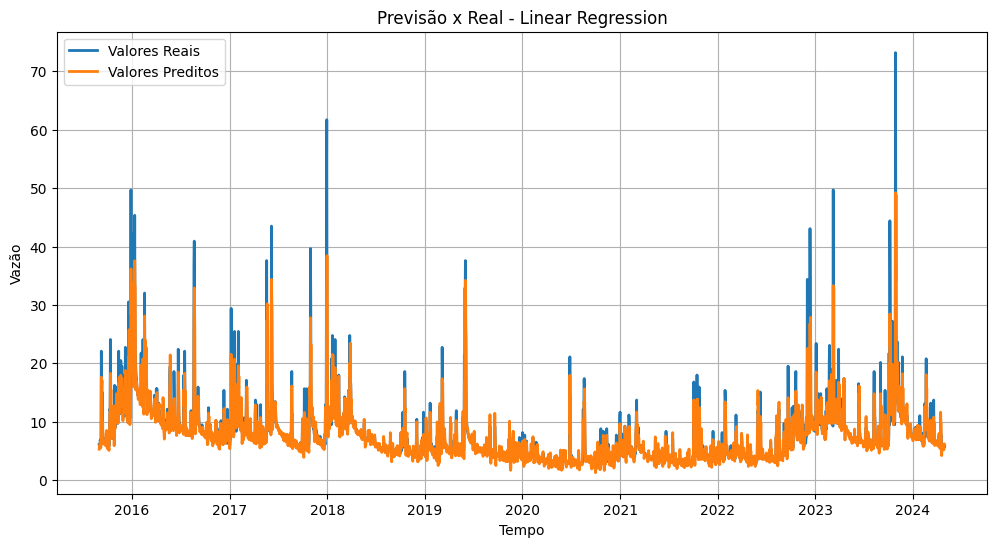

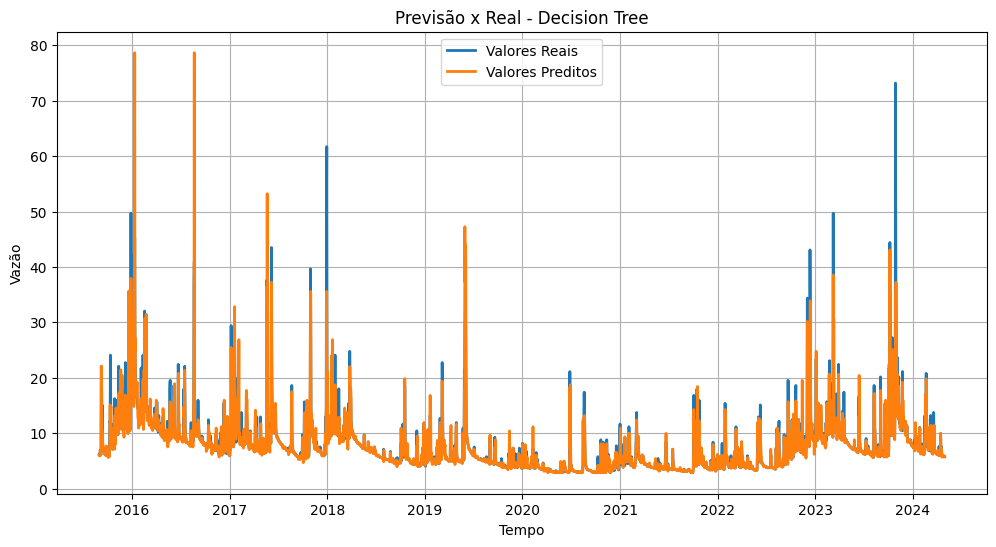

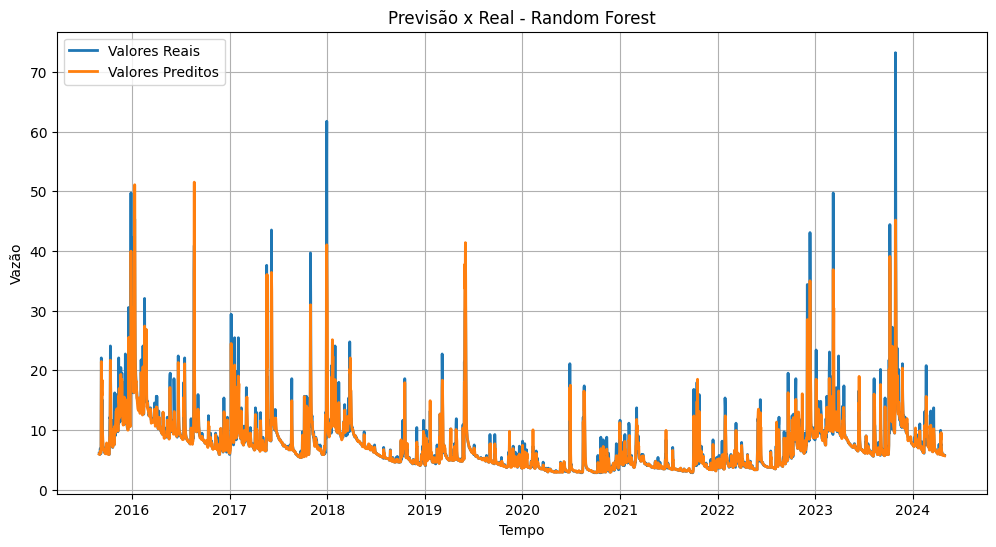

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5908
[LightGBM] [Info] Number of data points in the train set: 12660, number of used features: 30
[LightGBM] [Info] Start training from score 8.575524


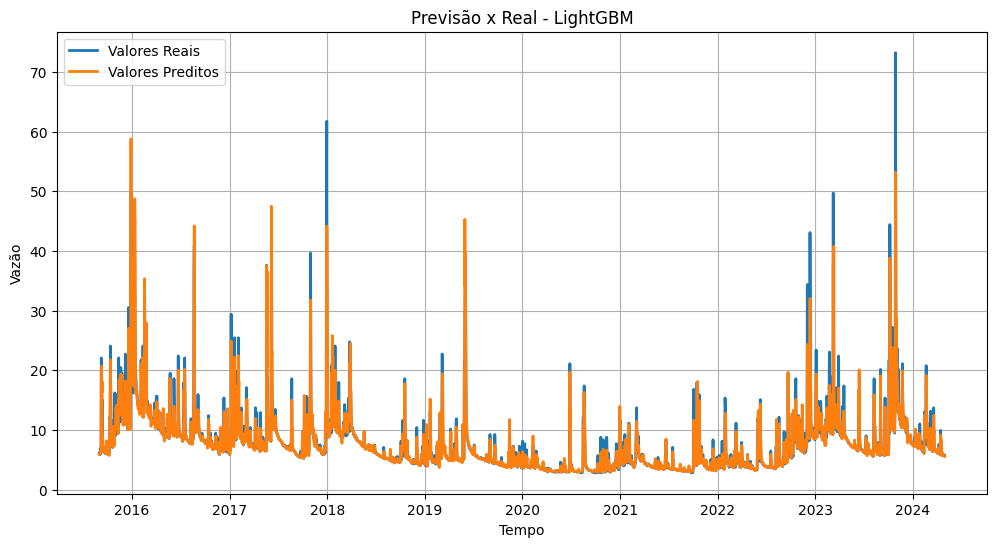

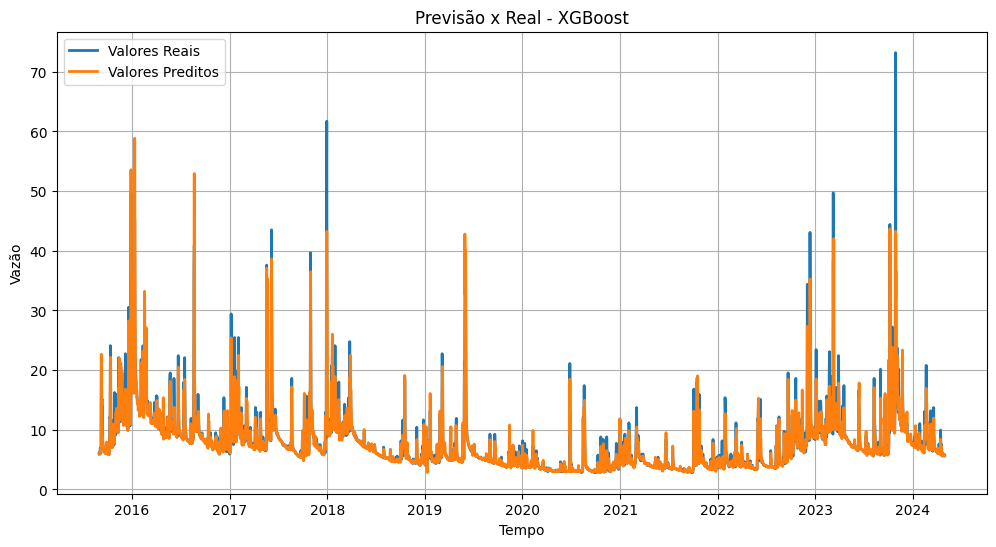

In [6]:
lin_reg = LinearRegression()
dec_tree = DecisionTreeRegressor(random_state=19)
ran_forest = RandomForestRegressor(random_state=19, n_estimators=500)
lgbm = LGBMRegressor(random_state=19, n_estimators=500)
xgb = XGBRegressor(random_state=19, n_estimators=500)

models_list = [
    ("Linear Regression", lin_reg),
    ("Decision Tree", dec_tree),
    ("Random Forest", ran_forest),
    ("LightGBM", lgbm),
    ("XGBoost", xgb)
]

results = []

for name, model in models_list:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append((name, evaluate_metrics(y_test, preds)))

    generate_graphic_prediction(y_test, preds, name)


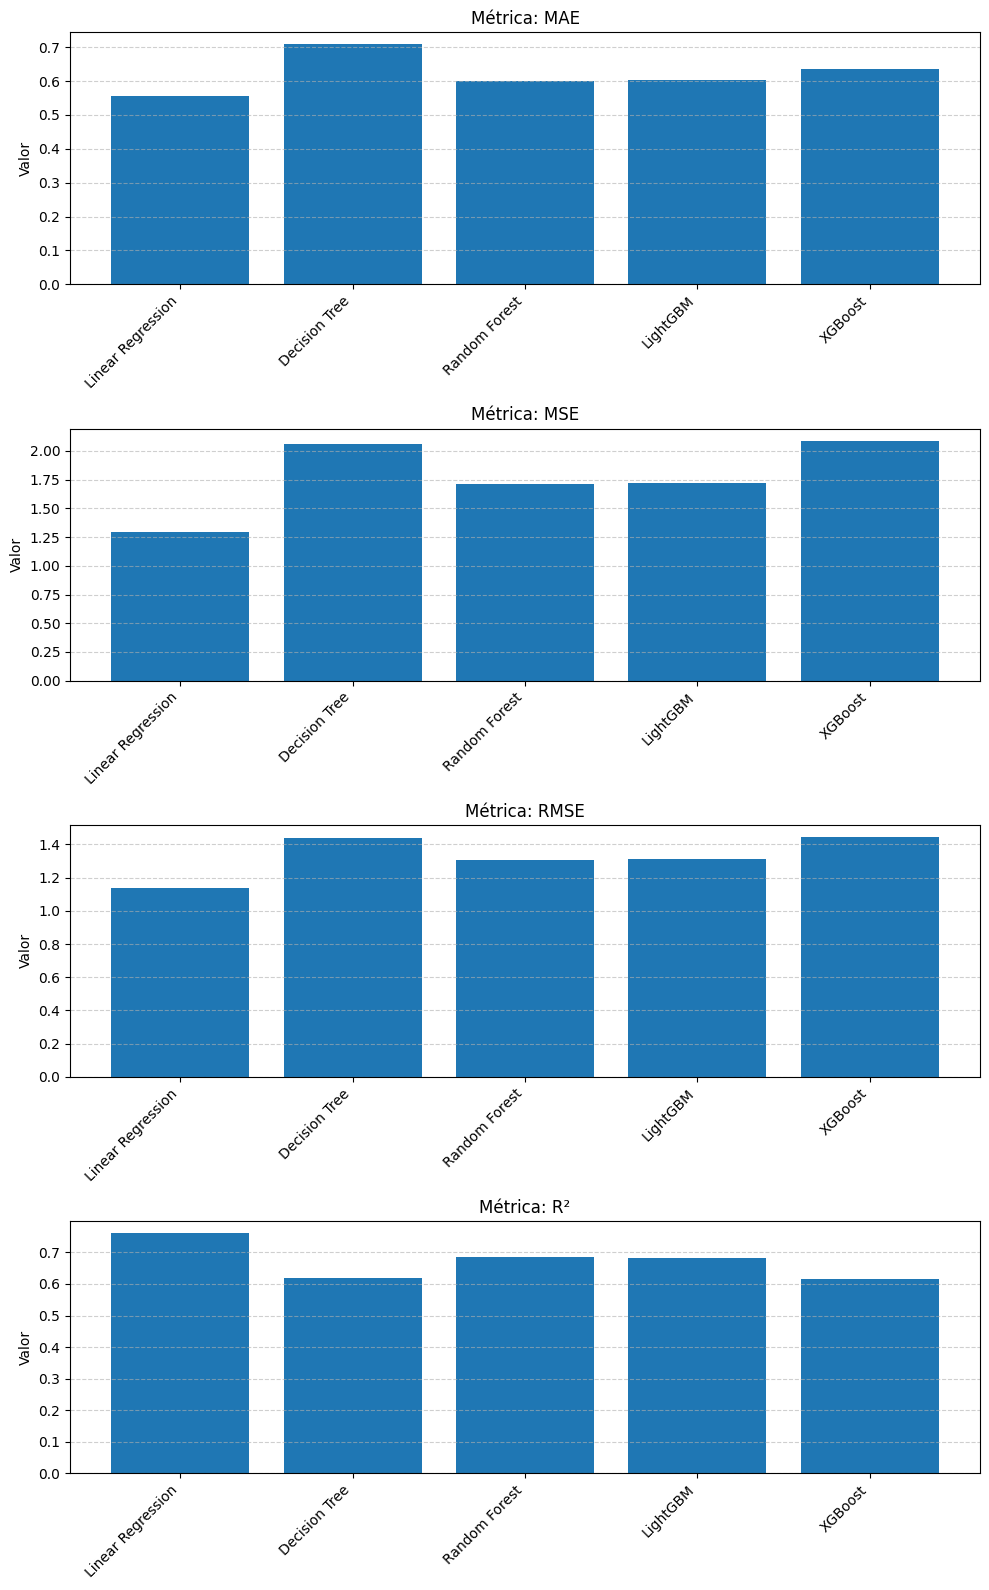

In [48]:
plot_metricas_modelos(results)

In [7]:
importances = xgb.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importance)

vazao_roll3_mean               0.733556
vazao_t1                       0.048482
precipitacao                   0.031091
precipitacao_roll3_mean        0.027939
estacao_inverno                0.026187
umidade_t1                     0.022136
vazao_roll9_mean               0.015675
mes_cos                        0.010821
vazao_roll6_mean               0.009371
umidade_relativa_roll9_mean    0.009203
umidade_relativa               0.009092
estacao_primavera              0.008856
umidade_relativa_roll3_mean    0.008794
precipitacao_roll6_mean        0.007304
temp_media                     0.006181
umidade_relativa_roll6_mean    0.005827
precipitacao_roll9_mean        0.004843
mes                            0.004654
estacao_outono                 0.004150
mes_sin                        0.002848
estacao_verao                  0.001504
vazao_roll6_sum                0.001403
vazao_roll3_sum                0.000081
vazao_roll9_sum                0.000000
precipitacao_roll3_sum         0.000000


## Interpretação das Métricas de Regressão
### 1. MAE — Mean Absolute Error (Erro Absoluto Médio)

**O que é:**

A média da diferença absoluta entre o valor real e o valor previsto.

**Interpretação:**

- Mostra em média quantas unidades o modelo erra.

- Tem interpretação direta: se MAE = 5, o modelo erra ~5 m³/s por dia.

- Não dá peso maior para erros grandes — todos erros têm a mesma importância.

**Bom para:**

- Quando queremos uma métrica fácil de entender e robusta.

### 2. MSE — Mean Squared Error (Erro Quadrático Médio)

**O que é:**

A média dos quadrados dos erros.

**Interpretação:**

- Penaliza muito mais erros grandes.

- Útil quando os outliers importam.

**Desvantagem:**

- Como é quadrático, a unidade não é mais m³/s, mas (m³/s)².

- Por isso geralmente preferimos o RMSE.

### 3. RMSE — Root Mean Squared Error (Raiz do Erro Quadrático Médio)

**O que é:**

A raiz quadrada do MSE.

**Interpretação:**

- Tem a mesma unidade da variável prevista (m³/s).

- Penaliza fortemente erros grandes.

- Quanto menor, melhor (igual ao MAE).

- É considerada a melhor métrica geral para séries temporais de vazão.

### 4. R² — Coeficiente de Determinação

**O que é:**

Mede quanto da variação da variável y o modelo explica.

**Interpretação:**

Vai de −∞ até 1.

- 1.0 → previsão perfeita

- 0.7 → o modelo explica 70% da variação

- 0.0 → o modelo não é melhor que prever a média

- valor negativo = o modelo é pior do que prever a média

**Observação importante:**

R² pode ser enganoso em séries temporais — use apenas como complemento.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definir hiperparâmetros para busca
param_grid = {
    'n_estimators': [300, 500, 700, 900],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=19)

# Random Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=19,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

best_rf = rf_random.best_estimator_
print("Melhores hiperparâmetros encontrados:")
print(rf_random.best_params_)

# Avaliação
preds = best_rf.predict(X_test)

evaluate_metrics(y_test, preds)
generate_graphic_prediction(y_test, preds, 'Random Forest Tunning')


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=5, max_features=0.7, min_samples_leaf=1, min_samples_split=2, n_estimators=700; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=8, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=700; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=20, n_estimators=700; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=700; total time=   0.7s
[CV] END bootstrap=True, max_depth=5, max_features=0.5, min_samples_leaf=8, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=0.3, min_samples_leaf=4, min_samples_split=20, n_estimators=700; total time=  

ValueError: 
All the 150 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/julia/Documents/ufsc/previsao-vazão-chuva/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/julia/Documents/ufsc/previsao-vazão-chuva/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/julia/Documents/ufsc/previsao-vazão-chuva/.venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py", line 359, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/home/julia/Documents/ufsc/previsao-vazão-chuva/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/julia/Documents/ufsc/previsao-vazão-chuva/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/home/julia/Documents/ufsc/previsao-vazão-chuva/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1099, in check_array
    raise ValueError(
ValueError: Found array with dim 3, while dim <= 2 is required by RandomForestRegressor.


In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt


2025-11-30 18:50:05.056666: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-30 18:50:05.369942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-30 18:50:08.284097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [9]:
df = pd.read_parquet('../data_lake/processed/dados_processados_9727.0_2025-11-27.parquet')
df_future = df[df['vazao'].isnull()]
df = df[df['vazao'].notnull()]

In [10]:
df_teste = df.copy()
df_teste.drop(columns=['codigo_bacia', 'codigo_sub_bacia', 'co_estacao', 'latitude', 'longitude', 'cidade', 'estado', 'rio'], inplace=True)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_teste)
df_scaled = pd.DataFrame(data_scaled, index=df_teste.index, columns=df_teste.columns)
df_scaled

,vazao,precipitacao,temp_media,umidade_relativa,vazao_t1,umidade_t1,vazao_roll3_mean,vazao_roll3_sum,vazao_roll6_mean,vazao_roll6_sum,...,umidade_relativa_roll6_sum,umidade_relativa_roll9_mean,umidade_relativa_roll9_sum,mes,mes_sin,mes_cos,estacao_inverno,estacao_outono,estacao_primavera,estacao_verao
data,,,,,,,,,,,,,,,,,,,,,
1981-01-01,0.036374,0.001570,0.726726,0.634436,0.036374,0.634436,0.037541,0.037541,0.071540,0.071540,...,0.723054,0.785539,0.785539,0.000000,0.750000,0.933013,0.0,0.0,0.0,1.0
1981-01-02,0.032668,0.000491,0.702648,0.617345,0.036374,0.634436,0.037541,0.037541,0.071540,0.071540,...,0.723054,0.785539,0.785539,0.000000,0.750000,0.933013,0.0,0.0,0.0,1.0
1981-01-03,0.030855,0.034351,0.743579,0.697895,0.032668,0.617345,0.037541,0.037541,0.071540,0.071540,...,0.723054,0.785539,0.785539,0.000000,0.750000,0.933013,0.0,0.0,0.0,1.0
1981-01-04,0.032668,0.098145,0.782504,0.781453,0.030855,0.697895,0.036148,0.036148,0.071540,0.071540,...,0.723054,0.785539,0.785539,0.000000,0.750000,0.933013,0.0,0.0,0.0,1.0
1981-01-05,0.052238,0.178820,0.755217,0.842855,0.032668,0.781453,0.043503,0.043503,0.071540,0.071540,...,0.723054,0.785539,0.785539,0.000000,0.750000,0.933013,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,0.030973,0.000785,0.743178,0.659282,0.031857,0.793005,0.035582,0.035582,0.049778,0.049778,...,0.625449,0.626682,0.626682,0.272727,0.933013,0.250000,0.0,1.0,0.0,0.0
2024-04-27,0.030095,0.002257,0.767657,0.602310,0.030973,0.659282,0.034920,0.034920,0.048809,0.048809,...,0.621569,0.624166,0.624166,0.272727,0.933013,0.250000,0.0,1.0,0.0,0.0
2024-04-28,0.030095,0.014329,0.794141,0.629530,0.030095,0.602310,0.034258,0.034258,0.048353,0.048353,...,0.633623,0.619153,0.619153,0.272727,0.933013,0.250000,0.0,1.0,0.0,0.0


In [11]:
def create_lstm_dataset(data, target_col="vazao", window=30):
    X, y = [], []
    target_idx = data.columns.get_loc(target_col)

    for i in range(window, len(data)):
        X.append(data.iloc[i-window:i].values)
        y.append(data.iloc[i, target_idx])
    
    return np.array(X), np.array(y)

WINDOW = 30
X_lstm, y_lstm = create_lstm_dataset(df_scaled, window=WINDOW)

In [12]:
y_lstm

array([0.05646514, 0.04811565, 0.04409691, ..., 0.03009477, 0.03009477,
       0.03009477], shape=(15796,))

In [13]:
split = int(len(X_lstm) * 0.8)
X_train, y_train = X_lstm[:split], y_lstm[:split]
X_test, y_test = X_lstm[split:], y_lstm[split:]

In [14]:
def build_model(hp):
    model = Sequential()

    # Configurações da CNN (opcional)
    use_cnn = hp.Boolean("use_cnn", default=True)
    cnn_filters = hp.Int("cnn_filters", min_value=16, max_value=128, step=16)
    cnn_kernel = hp.Choice("cnn_kernel", values=[2, 3, 5])

    # Configurações da LSTM
    lstm_units = hp.Int("lstm_units", min_value=16, max_value=128, step=16)
    num_layers = hp.Int("num_layers", min_value=1, max_value=2)

    # Camada CNN inicial (se habilitada)
    if use_cnn:
        model.add(Conv1D(
            filters=cnn_filters,
            kernel_size=cnn_kernel,
            activation="relu",
            padding="causal",
            input_shape=(WINDOW, X_lstm.shape[2])
        ))
        model.add(MaxPooling1D(pool_size=2))
        lstm_input = None
    else:
        lstm_input = (WINDOW, X_lstm.shape[2])

    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        lstm_kwargs = {
            "units": lstm_units,
            "activation": "tanh",
            "return_sequences": return_sequences,
        }
        if lstm_input is not None and i == 0:
            lstm_kwargs["input_shape"] = lstm_input
        model.add(LSTM(**lstm_kwargs))

    # Dropout
    model.add(Dropout(hp.Float("dropout", 0.0, 0.5, step=0.1)))

    # Dense intermediária
    model.add(Dense(
        hp.Int("dense_units", 16, 128, step=16),
        activation="relu"
    ))

    # Saída
    model.add(Dense(1))

    # Learning Rate
    lr = hp.Choice("learning_rate", [1e-4, 5e-4, 1e-3, 5e-3])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )

    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=20,
    directory="tuning",
    project_name="lstm_flow"
)

early_stop = EarlyStopping(monitor="val_loss", patience=5)

tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Melhor hiperparâmetro encontrado
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Melhores Hiperparâmetros:")
print(best_hp.values)


Trial 20 Complete [00h 00m 48s]
val_loss: 0.0009919673902913928

Best val_loss So Far: 0.0009310415480285883
Total elapsed time: 00h 20m 30s
Melhores Hiperparâmetros:
{'use_cnn': False, 'cnn_filters': 80, 'cnn_kernel': 3, 'lstm_units': 80, 'num_layers': 1, 'dropout': 0.1, 'dense_units': 16, 'learning_rate': 0.0005}


In [15]:
best_params = best_hp.values

model_final = Sequential()

# Camada CNN opcional
if best_params.get('use_cnn', True):
    model_final.add(Conv1D(
        filters=best_params.get('cnn_filters', best_params['lstm_units']),
        kernel_size=best_params.get('cnn_kernel', 3),
        activation='relu',
        padding='causal',
        input_shape=(WINDOW, X_lstm.shape[2])
    ))
    model_final.add(MaxPooling1D(pool_size=2))
    lstm_input = None
else:
    lstm_input = (WINDOW, X_lstm.shape[2])

# Camadas LSTM (1 ou 2)
num_layers = best_params.get('num_layers', 1)
for i in range(num_layers):
    return_sequences = i < num_layers - 1
    lstm_kwargs = {
        'units': best_params['lstm_units'],
        'activation': 'tanh',
        'return_sequences': return_sequences,
    }
    if lstm_input is not None and i == 0:
        lstm_kwargs['input_shape'] = lstm_input
    model_final.add(LSTM(**lstm_kwargs))

# Dropout
model_final.add(Dropout(best_params['dropout']))

# Dense intermediária
model_final.add(Dense(best_params['dense_units'], activation='relu'))

# Saída
model_final.add(Dense(1))

# Compilar
model_final.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='mse'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_final = model_final.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = model_final.predict(X_test)

# desnormalizar
def inverse_scale(value):
    scaler_y = MinMaxScaler().fit(df_teste['vazao'].values.reshape(-1,1))
    return scaler_y.inverse_transform(value)

y_test_real = inverse_scale(y_test.reshape(-1,1)).flatten()
y_pred_real = inverse_scale(y_pred_scaled).flatten()


Epoch 1/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 6/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 7/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.9349e-04 - val_loss: 0.0011
Epoch 11/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.7472e-04 - val_loss: 0.0011
Epoch 12/100
316/316 ━━━━━━━━━━━━

{'MAE': 1.249697974286502, 'MSE': 8.263797579160684, 'RMSE': np.float64(2.8746821701121474), 'R²': 0.6679070585718838}


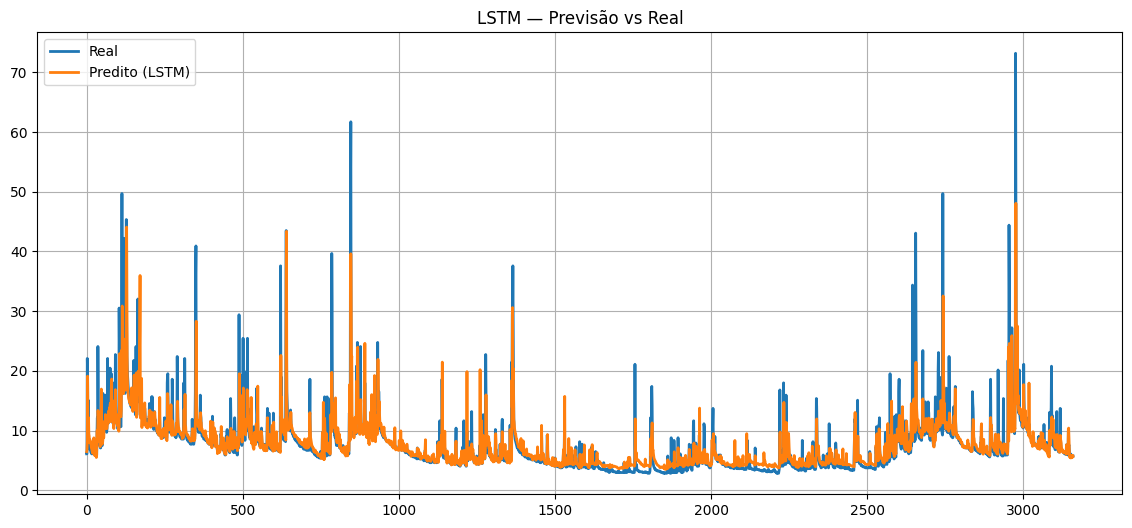

In [16]:
print(evaluate_metrics(y_test=y_test_real, y_pred=y_pred_real))

plt.figure(figsize=(14,6))
plt.plot(y_test_real, label="Real", linewidth=2)
plt.plot(y_pred_real, label="Predito (LSTM)", linewidth=2)
plt.legend()
plt.title("LSTM — Previsão vs Real")
plt.grid(True)
plt.show()